<a href="https://colab.research.google.com/github/ridhiaggarwal06/ecommerce-review-prediction/blob/main/E_commerce_review_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np

### Upload data from Local system

In [ ]:
upload files
from google.colab import files
uploaded = files.upload()

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [ ]:
# read files
review = pd.read_csv("olist_order_reviews_dataset.csv")
order = pd.read_csv("olist_orders_dataset.csv")
payment = pd.read_csv("olist_order_payments_dataset.csv")
customer = pd.read_csv("olist_customers_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
seller = pd.read_csv("olist_sellers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")

### Merge all dataframes into a master dataset

In [ ]:
# Merging all relevant datasets into one final DataFrame based on common keys
# This includes review, order, payment, customer, items, product, and seller data
df_final = pd.merge(review,order,how="left",on="order_id")
df_final = pd.merge(df_final,payment,how="left",on="order_id")
df_final = pd.merge(df_final,customer,how="left",on="customer_id")
df_final = pd.merge(df_final,items,how="left",on="order_id")
df_final = pd.merge(df_final,product,how="left",on="product_id")
df_final = pd.merge(df_final,seller,how="left",on="seller_id")

In [ ]:
# Saving the merged dataset to a CSV file for future use
df_final.to_csv("data.csv")

In [ ]:
# Loading the saved merged dataset
# Index column (0) is the default index created by pandas
df = pd.read_csv("data.csv",index_col=0)

<ipython-input-6-c10251d9f55f>:2: DtypeWarning: Columns (3,17,20,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv",index_col=0)


## Data processing

In [ ]:
# remove any duplicate rows
df = df.drop_duplicates()

#sum(payment_value) in same order id
df = df.drop(columns=["payment_sequential"])
df = df.drop(columns=["payment_type"])

# Group by relevant columns and sum payment values while retaining the first occurrence of all other columns
result = (df.groupby(["order_id", "order_item_id","review_id","product_id","customer_id"], as_index=False)
    .agg({"payment_value": "sum",
        **{col: "first" for col in df.columns if col not in ["order_id", "order_item_id", "payment_value"]}}))

# Add a new column: number of times each product appears in an order
result["item_number"] = result.groupby(["order_id", "product_id"])["product_id"].transform("count")

# Drop duplicate combinations of order_id and product_id to avoid repetition
results = result.drop_duplicates(subset=["order_id", "product_id"])

In [ ]:
# Set the cleaned result as the new working DataFrame
df=results

In [ ]:
# Save the updated dataset
df.to_csv("111.csv")

## Data cleaning

### Payment consistency check

In [ ]:
# Round payment value to 2 decimals
#check if payment more than total price: drop 150rows
df.loc[:, "payment_value"] = df["payment_value"].round(2)

# Calculate individual product price (including freight) * quantity
#iprice = total price of one product in one order
df.loc[:, "iprice"] = ((df["freight_value"] + df["price"]) * df["item_number"])\

# Calculate total price per order by summing individual product prices
df.loc[:, "totalprice"] = df.groupby(["order_id", "review_id"])["iprice"].transform("sum")
df.loc[:, "totalprice"] = df["totalprice"].round(2)

# Remove orders where payment was higher than the total price (possible data error)
condition = df["payment_value"].round(-1) > df["totalprice"].round(-1)
check1 = df[condition]  # Can be printed for inspection

print(check1)

# Keep only valid rows
df = df[~condition]

<ipython-input-10-ec4be7bbdd80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "iprice"] = ((df["freight_value"] + df["price"]) * df["item_number"])
<ipython-input-10-ec4be7bbdd80>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "totalprice"] = df.groupby(["order_id", "review_id"])["iprice"].transform("sum")


                                order_id  order_item_id  payment_value  \
157     00789ce015e7e5791c7914f32bb4fad4            1.0         190.81   
533     016726239765c18f66826453f39c64e3            1.0         265.77   
731     01e51b7c3025655646143d09b911e1d7            1.0          35.02   
1138    02f4dd90ba0feb8ec394cac05862d2b5            1.0         141.65   
1248    033ccfbdfc4d29677b7e1e6df3a82820            1.0          69.26   
...                                  ...            ...            ...   
98804   f7d17bafe7c67afef77b8a96ad5abfd3            1.0         115.64   
99693   fa0d5b3cb1f2221766145a60ba18ac64            1.0         141.32   
99912   fa87437f971fce498b2184cd2401e23e            1.0          66.93   
100064  faf132fb35b3b3b533a67efbd6e7c02d            1.0         130.01   
100466  fbf352b18a26c6a86a53cca922facd25            1.0         160.80   

                               review_id review_score review_comment_title  \
157     e880864e64f669aea8904ee3f

### Convert date columns to proper `datetime` format

In [ ]:
# Convert review-related dates
df.loc[:, 'review_creation_date'] = pd.to_datetime(df['review_creation_date'], dayfirst=True, errors='coerce')
df.loc[:, 'review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'], dayfirst=True, errors='coerce')

In [ ]:
# Convert all other timestamp-related columns
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_estimated_delivery_date',
    'order_delivered_customer_date',
    'shipping_limit_date'
]

for col in date_columns:
    df.loc[:, col] = pd.to_datetime(df[col], errors='coerce')

### Validate order status against delivery data

In [ ]:
# Find inconsistencies: marked as delivered but no delivery date
falsedelivered = df[(df['order_status'] == 'delivered') & (df['order_delivered_customer_date'].isnull())]   #7 rows
print(falsedelivered)

# Find inconsistencies: not marked as delivered but has a delivery date
falseundelivered = df[(df['order_status'] != 'delivered') & (df['order_delivered_customer_date'].notna())]   #7 rows
print(falseundelivered)

                               order_id  order_item_id  payment_value  \
5307   0d3268bad9b086af767785e3f0fc0133            1.0         204.62   
13123  20edc82cf5400ce95e1afacc25798b31            1.0          54.97   
17781  2d1e2d5bf4dc7227b3bfebb81328c15f            1.0         134.83   
17952  2d858f451373b04fb5c984a1cc2defaf            1.0         194.00   
18463  2ebdfc4f15f23b91474edf87475f108e            1.0         158.07   
68227  ab7c89dc1bf4a1ead9d6ec1ec8968a84            1.0         120.12   
92070  e69f75a717d64fc5ecdfae42b2e8e086            1.0         158.07   

                              review_id review_score review_comment_title  \
5307   ee2d30652e2f7fc00861074f795f5bf0            5           Excelente!   
13123  d055795a562efffefe47ef81e5435322            5            Muito bom   
17781  f48c6c944a5d52dcca8ac5c4ec417cf2            5                 None   
17952  4e755f114e50d33b9ac6a56e0d7d3ea9            5                 None   
18463  25e11638a3d01a87e8e6233

In [ ]:
# Check if review creation date later than review answer date:
reviewwrong = df[df['review_creation_date'] > df['review_answer_timestamp']]     #0 row
print(reviewwrong)

Empty DataFrame
Columns: [order_id, order_item_id, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, payment_installments, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, product_id, seller_id, shipping_limit_date, price, freight_value, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, seller_zip_code_prefix, seller_city, seller_state, item_number, iprice, totalprice]
Index: []

[0 rows x 40 columns]


In [ ]:
# Check if purchase date later than approved date and if approved date later than order post date
paytimewrong = df[df['order_purchase_timestamp'] > df['order_approved_at']]        #0 row
posttimewrong=df[df['order_approved_at'] > df['order_delivered_carrier_date']]     #1276 rows
print(paytimewrong)
print(posttimewrong)

Empty DataFrame
Columns: [order_id, order_item_id, payment_value, review_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, payment_installments, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, product_id, seller_id, shipping_limit_date, price, freight_value, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm, seller_zip_code_prefix, seller_city, seller_state, item_number, iprice, totalprice]
Index: []

[0 rows x 40 columns]
                                order_id  order_item_id  payment_value  \
7       000576fe39319847cbb9d288c5617fa6            1.0         880.75   
47      002175704e8b209f61b9ad5cfd92b60e            1.0 

In [ ]:
# Check if post date later than estimated date
estimatetimewrong=df[df['order_delivered_carrier_date'] > df['order_estimated_delivery_date']] #436 rows
print(estimatetimewrong)


deliveredtimewrong=df[df['order_delivered_carrier_date'] > df['order_delivered_customer_date']] #35 rows
print(deliveredtimewrong)

                                order_id  order_item_id  payment_value  \
41      001d8f0e34a38c37f7dba2a37d4eba8b            1.0          53.54   
194     009742b43f4530bc3db7f62332c50f4b            1.0         146.18   
271     00c00d5b36157595e21108ba1da2828f            1.0         312.92   
320     00e054d0da011d5016f31011af488f4f            1.0         118.82   
879     024a74550cdbd36c0fe3955fc9e2bcf0            1.0          35.45   
...                                  ...            ...            ...   
100978  fd2abbf4e0f632ba709f0059c02da633            1.0          36.45   
101308  fe0105a4696c7d31837cb3130fe9c4b1            1.0         103.55   
101355  fe225fc0702b1d46a931e88d60c7be25            1.0          66.14   
101435  fe58b25c8ebdc65c3d4cb34070bf9e5d            1.0          69.03   
101820  ff49f52e3e1a9422bc1899208d5b8591            1.0          32.68   

                               review_id review_score review_comment_title  \
41      51ebb8fede4fbe6126f9f85eb

### Validate Delivery Timings vs. Order Timestamps

In [ ]:
# Check if the order was shipped later than the allowed shipping deadline
# These rows might indicate logistic issues or data errors
shippinglimittimewrong=df[df['order_delivered_carrier_date'] > df['shipping_limit_date']]     # 8,214 rows

# Check if delivery to the customer occurred before the official shipping limit date
# This could suggest early deliveries or incorrect shipping limit entries
shippinglimittimewrong2=df[(df['order_delivered_customer_date'].notna()) & (df['shipping_limit_date'] > df['order_delivered_customer_date'])
] # 18,720 rows

# Display mismatches for review
print(shippinglimittimewrong)
print(shippinglimittimewrong2)

                                order_id  order_item_id  payment_value  \
0       00010242fe8c5a6d1ba2dd792cb16214            1.0          72.19   
1       00018f77f2f0320c557190d7a144bdd3            1.0         259.83   
4       00042b26cf59d7ce69dfabb4e55b4fd9            1.0         218.04   
8       0005a1a1728c9d785b8e2b08b904576c            1.0         157.60   
32      0014ae671de39511f7575066200733b7            1.0          30.60   
...                                  ...            ...            ...   
102030  ffe49171e120186dcc4c444b55691810            1.0          76.85   
102047  ffeeb911d070bea3dd20bd5fd01da5e8            1.0          95.69   
102054  fff3983dfa3c5a0d752d8d17baa406a0            1.0          80.44   
102065  fffb9224b6fc7c43ebb0904318b10b5f            1.0         356.76   
102069  fffbee3b5462987e66fb49b1c5411df2            1.0         139.88   

                               review_id review_score review_comment_title  \
0       97ca439bc427b48bc1cd7177a

This is an important validation step to ensure the timestamp logic holds:

    Purchase → Shipping Limit → Carrier Pickup → Customer Delivery
    Any inversion in this order suggests potential data entry or operational issues.

In [ ]:
# Drop all rows where order status and delivery dates contradict each other
df = df.drop(falsedelivered.index.union(falseundelivered.index))

# Drop rows where delivery dates don't follow expected order (purchase → delivery)
df = df.drop(estimatetimewrong.index)
df = df.drop(deliveredtimewrong.index)

In [ ]:
# Save the fully cleaned dataset to CSV
df.to_csv("afterclean.csv", index=False)

In [ ]:
# Store final cleaned DataFrame for further analysis and modeling
afterclean = df    # Contains 91,646 rows

### Calculate Delivery and Review Times

In [ ]:
# Reassign the cleaned dataset to df
df=afterclean

# Calculate how long it took to deliver the order and how long it took to respond to the review
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['review_time'] = df['review_answer_timestamp'] - df['review_creation_date']

# Fill missing delivery times with 0 (e.g., where dates may be missing)
df['delivery_time'] = df['delivery_time'].fillna(0)

### Estimate Product Size (Volume)

In [ ]:
# Ensure all size dimensions are numeric
df['product_length_cm'] = pd.to_numeric(df['product_length_cm'], errors='coerce')
df['product_height_cm'] = pd.to_numeric(df['product_height_cm'], errors='coerce')
df['product_width_cm'] = pd.to_numeric(df['product_width_cm'], errors='coerce')

# Calculate product volume (length × height × width)
df['size'] = df['product_length_cm']* df['product_height_cm']*df["product_width_cm"]

### Categorize Delivery Status

In [ ]:
# Create a new column `status` with numeric encoding for order outcome
def classify_row(row):
    if row['order_status'] == 'delivered':
        if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date']:
            return 1
        else:
            return 2
    elif row['order_status'] in ['canceled', 'unavailable']:
        return 0
    elif row['order_status'] == 'shipped':
        return 3
    else:
        return 4
df['status'] = df.apply(classify_row, axis=1)

### Encode Product Categories

In [ ]:
# Convert product categories into categorical codes
df['product_category_name'] = df['product_category_name'].astype('category')
df['category'] = df['product_category_name'].cat.codes

### Compute Review Score Averages

In [ ]:
# Convert review scores to numeric type
df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce')

# Calculate average review score by seller
df['mean_review_score_seller'] = df.groupby('seller_id')['review_score'].transform('mean')

In [ ]:
# Calculate average review score by product id
df['mean_review_score_product'] = df.groupby('product_id')['review_score'].transform('mean')

# Calculate average review score by product category
df['mean_review_score_productcategory'] = df.groupby('category')['review_score'].transform('mean')

In [ ]:
# Save the complete dataset before narrowing down to model input features
df1 = df
df1.to_csv("beforechoosing.csv", index=False)

In [ ]:
# Retain only the relevant columns for machine learning
df=df1
columns_to_keep = ['review_score','payment_value', 'review_time',
               'status', 'delivery_time', 'payment_installments',
               'price', 'freight_value','category','product_name_lenght',
               'product_description_lenght','product_photos_qty',
               'product_weight_g','size','item_number',
               'mean_review_score_product','mean_review_score_seller','mean_review_score_productcategory']

### Check and Drop Missing Data

In [ ]:
# Display number of missing values in selected columns
na_counts = df[columns_to_keep].isna().sum()
has_na = df[columns_to_keep].isna().any()

print("na number：\n", na_counts)

na number：
 review_score                            2
payment_value                           0
review_time                             2
status                                  0
delivery_time                           0
payment_installments                    0
price                                   0
freight_value                           0
category                                0
product_name_lenght                  1296
product_description_lenght           1296
product_photos_qty                   1296
product_weight_g                       15
size                                   17
item_number                             0
mean_review_score_product               2
mean_review_score_seller                2
mean_review_score_productcategory       2
dtype: int64


In [ ]:
# Drop rows with missing values and convert review scores to binary labels (0 = negative, 1 = positive)
df = df[columns_to_keep]
df = df.dropna()
df.loc[:, 'review_score'] = df['review_score'].apply(lambda x: 0 if x <= 3 else 1)

In [ ]:
df   # Contains 90,347 rows

,review_score,payment_value,review_time,status,delivery_time,payment_installments,price,freight_value,category,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,size,item_number,mean_review_score_product,mean_review_score_seller,mean_review_score_productcategory
0,1.0,72.19,1 days 10:57:00,1,7 days 14:44:46,2.0,58.90,13.29,28,58.0,598.0,4.0,650.0,3528.0,1,4.428571,4.000000,4.155405
1,1.0,259.83,2 days 11:34:00,1,16 days 05:11:18,3.0,239.90,19.93,65,56.0,239.0,2.0,30000.0,60000.0,1,4.000000,3.837838,4.217197
2,1.0,216.87,0 days 16:06:00,1,7 days 22:45:45,5.0,199.00,17.87,56,59.0,695.0,2.0,3050.0,14157.0,1,4.500000,4.111111,3.981624
3,1.0,25.78,0 days 16:39:00,1,6 days 03:32:04,2.0,12.99,12.79,64,42.0,480.0,1.0,200.0,2400.0,1,4.000000,4.666667,4.194742
4,1.0,218.04,1 days 10:54:00,1,25 days 02:44:40,3.0,199.90,18.14,42,59.0,409.0,1.0,3750.0,42000.0,1,3.727273,3.720000,4.122386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102070,1.0,343.40,3 days 12:53:00,1,17 days 08:59:34,1.0,299.99,43.41,74,43.0,1002.0,3.0,10150.0,53400.0,1,4.150000,4.150000,4.123788
102071,1.0,386.53,1 days 09:25:00,1,9 days 10:05:09,1.0,350.00,36.53,46,31.0,232.0,1.0,8950.0,44460.0,1,4.500000,4.214286,4.000162
102072,1.0,116.85,0 days 21:33:00,1,4 days 19:14:26,3.0,99.90,16.95,34,43.0,869.0,1.0,967.0,9576.0,1,4.700000,4.460317,4.152780
102073,1.0,64.71,1 days 12:24:00,1,1 days 22:56:41,3.0,55.99,8.72,46,56.0,1306.0,1.0,100.0,8000.0,1,4.700000,4.526316,4.000162


In [ ]:
# Set the final cleaned DataFrame
dfnew = df

In [ ]:
# Save it for backup
dfnew.to_csv("datafinial.csv", index=False)

## 1 Model using average columns


In [ ]:
# Preview datatypes to ensure compatibility for ML
df = dfnew
print(df.dtypes)

review_score                         float64
payment_value                        float64
review_time                           object
status                                 int64
delivery_time                         object
payment_installments                  object
price                                float64
freight_value                        float64
category                                int8
product_name_lenght                  float64
product_description_lenght           float64
product_photos_qty                   float64
product_weight_g                      object
size                                 float64
item_number                            int64
mean_review_score_product            float64
mean_review_score_seller             float64
mean_review_score_productcategory    float64
dtype: object


Some columns like `review_time`, `delivery_time`, `payment_installments` and `product_weight_g` are stored as objects and must be converted before modeling.

In [ ]:
df=dfnew

# Convert timedelta columns to numeric (int, in nanoseconds)
df['review_time'] = pd.to_timedelta(df['review_time'], errors='coerce')
df['delivery_time'] = pd.to_timedelta(df['delivery_time'], errors='coerce')
df['review_time'] = df['review_time'].astype(int)
df['delivery_time'] = df['delivery_time'].astype(int)

# Convert relevant columns to float
df['payment_installments'] = df['payment_installments'].astype(float)
df['product_weight_g'] = df['product_weight_g'].astype(float)

# Define target and features
y_value = df['review_score'] # set the y
y_values = np.ravel(y_value) # convert to array (list)
x_values = df.drop('review_score', axis=1)

In [ ]:
from sklearn.model_selection  import train_test_split

# Stratified split to preserve class ratio
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# Check shape and types
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_test.columns)
print(X_test.dtypes)

(72277, 17)
(18070, 17)
(72277,)
(18070,)
Index(['payment_value', 'review_time', 'status', 'delivery_time',
       'payment_installments', 'price', 'freight_value', 'category',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'size', 'item_number',
       'mean_review_score_product', 'mean_review_score_seller',
       'mean_review_score_productcategory'],
      dtype='object')
payment_value                        float64
review_time                            int64
status                                 int64
delivery_time                          int64
payment_installments                 float64
price                                float64
freight_value                        float64
category                                int8
product_name_lenght                  float64
product_description_lenght           float64
product_photos_qty                   float64
product_weight_g                     float64
size                

### Train Machine Learning Models

We use two tree-based ensemble models: Gradient Boosting Decision Trees (GBDT) and XGBoost.

In [ ]:
# Import models
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support

# Train both models
GBDT_algo = GBDT()
GBDT_model = GBDT_algo.fit(X_train, Y_train)
XGB_algo = XGB()
XGB_model = XGB_algo.fit(X_train, Y_train)

# Store models for batch evaluation
models = [ GBDT_model, XGB_model]
names = ['GBDT', 'XGBDT']

### Evaluate Model Performance on Training Data

In [ ]:
# Store models and names for easier evaluation
models = [ GBDT_model, XGB_model]
names = ['GBDT', 'XGBDT']


# Evaluate training performance for both models (GBDT and XGB)
# Using macro-average metrics to treat both classes equally

for i in range(2):
  print(f"Model: {names[i]}")

  # Predict on training data
  predict = models[i].predict(X_train)

  # Calculate macro precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')

  # Display performance metrics
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: GBDT
Macro Precision: 0.8281911673658939
Macro Recall: 0.7508022964588501
Macro F1-score: 0.7782817424701021


Model: XGBDT
Macro Precision: 0.8813715380071094
Macro Recall: 0.7896943497718878
Macro F1-score: 0.8226420067168267




### Evaluate Model Performance on Test Data

In [ ]:
# Evaluate test performance for both models using macro-average metrics
for i in range(2):
  print(f"Model: {names[i]}")

  # Predict on test data
  predict = models[i].predict(X_test)

  # Calculate precision, recall, and F1 for test data
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

  # Display metrics
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: GBDT
Macro Precision: 0.8239623317849835
Macro Recall: 0.749303598301215
Macro F1-score: 0.7760049289116404


Model: XGBDT
Macro Precision: 0.8216139988347683
Macro Recall: 0.7461623846753587
Macro F1-score: 0.7729304788064897




### Model Accuracy & Classification Report

In [ ]:
# Import accuracy and classification report functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Predict class labels from probabilities using GBDT model on test data
y_pred_prob = GBDT_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print accuracy and full classification report
print("GBDT Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

# Repeat for XGB model
y_pred_prob = XGB_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print("XGB Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

GBDT Accuracy: 0.8570005534034311

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.55      0.64      4222
         1.0       0.87      0.95      0.91     13848

    accuracy                           0.86     18070
   macro avg       0.82      0.75      0.78     18070
weighted avg       0.85      0.86      0.85     18070

XGB Accuracy: 0.8553403431101273

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.54      0.64      4222
         1.0       0.87      0.95      0.91     13848

    accuracy                           0.86     18070
   macro avg       0.82      0.75      0.77     18070
weighted avg       0.85      0.86      0.85     18070



Since the default XGBoost model shows slight overfitting, we use random search to find better hyperparameters.


### Hyperparameter Tuning with Random Search

In [ ]:
# Import libraries for randomized hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Suppress warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Define a reusable function to perform RandomizedSearchCV
def random_search(algo, hyperparameters, X_train, Y_train):

    """
    Perform random search on given algorithm with specified hyperparameter ranges.
    Returns the best hyperparameter set found.

    """

  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(
                           algo,                           # Model/Algorithm to tune
                           hyperparameters,                # Hyperparameter search space
                           cv=5,                           # 5-fold cross-validation
                           random_state=2015,              # For reproducibility
                           scoring='precision_macro',      # Metric to optimise
                           n_iter=20,                      # Number of random combinations to try
                           refit=True                      # Fit final model with best params
)

  # Fit on training data
  clf.fit(X_train, Y_train)

  # Return best parameters found
  return clf.best_params_

We define a reusable function to automatically search for the best model settings using RandomizedSearchCV. This helps improve performance by trying different combinations of parameters like learning rate, depth, and number of trees.

### Define Search Space and Run Tuning

In [ ]:
# Define Hyperparameter Ranges

XGB_tuned_parameters = {
    'n_estimators': randint(25, 250), # Number of trees
    'eta': uniform(loc=0.01, scale=4.99),  # Learning rate
    'objective': ['binary:logistic', 'binary:hinge'], # objective is the same as criterion
    'max_depth': randint(2, 7)  # Tree depth
}

# Run tuning and print the best hyperparameters
XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, X_train, Y_train)

### Train and Evaluate the Tuned XGB Model

In [ ]:
# Train the XGB model using the best found parameters
XGB_algo = XGB(**XGB_best_params)
XGB_model = XGB_algo.fit(X_train, Y_train)


# Define a list for evaluation
models = [XGB_model]
names = ['XGBDT']

# Evaluate model performance on training data
for i in range(1):
  print(f"train score")
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_train)

  # Calculate macro-average precision, recall, F1
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')

  # Print metrics
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

# Evaluate model performance on test data
for i in range(1):
  print(f"test score")
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_test)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

train score
Model: XGBDT
Macro Precision: 0.8066141787330807
Macro Recall: 0.7504625989656812
Macro F1-score: 0.7720246594420472


test score
Model: XGBDT
Macro Precision: 0.8041204278564478
Macro Recall: 0.7485452976499811
Macro F1-score: 0.7698792542562322




We retrain the XGB model using the best parameters and check its performance on both training and testing data using precision, recall, and F1-score.

### Final Accuracy and Classification Report (XGB Tuned)

In [ ]:
# Make final predictions on test data
y_pred_prob = XGB_model.predict(X_test)  # get probabilities or predictions
y_pred = (y_pred_prob > 0.5).astype(int) # convert to binary labels if needed

# Print accuracy
print("XGB Accuracy:", accuracy_score(Y_test, y_pred))

# Print detailed classification report
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

XGB Accuracy: 0.849529607083564

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.56      0.63      4222
         1.0       0.87      0.94      0.91     13848

    accuracy                           0.85     18070
   macro avg       0.80      0.75      0.77     18070
weighted avg       0.84      0.85      0.84     18070



### Plot Confusion Matrix for Tuned model

GBDT Confusion Matrix
XGB Confusion Matrix


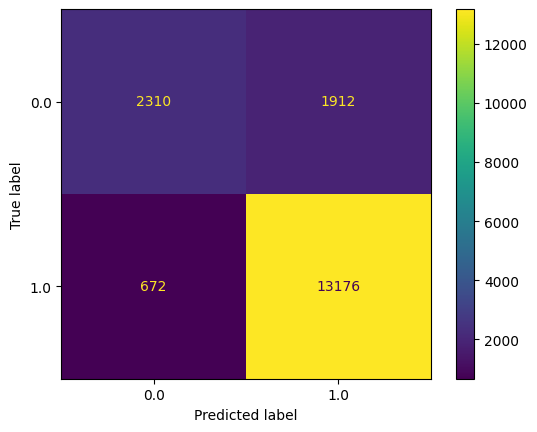

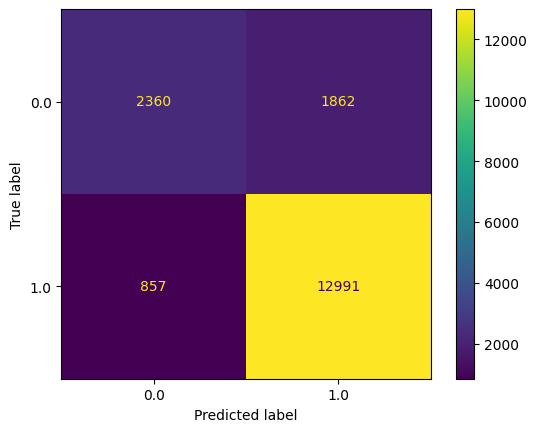

In [ ]:
# Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay as CM

# GBDT
print("GBDT Confusion Matrix")
predict = GBDT_model.predict(X_test)
print(CM.from_predictions(Y_test, predict))

# XGBoost
print("XGB Confusion Matrix")
predict = XGB_model.predict(X_test)
CM.from_predictions(Y_test, predict)

### GBDT Feature Importance Plot

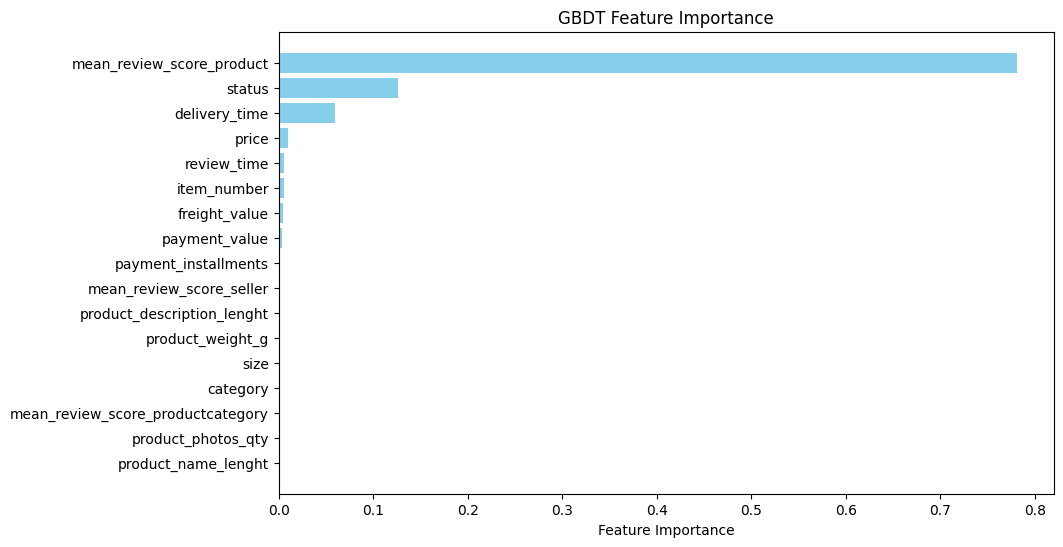

In [ ]:
# Feature importance for GBDT Model
import matplotlib.pyplot as plt
importances = GBDT_model.feature_importances_

X_train.columns=['payment_value', 'review_time',
               'status', 'delivery_time', 'payment_installments',
               'price', 'freight_value','category','product_name_lenght',
               'product_description_lenght','product_photos_qty',
               'product_weight_g','size','item_number',
               'mean_review_score_product','mean_review_score_seller','mean_review_score_productcategory']
features = X_train.columns

# Sort and plot
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('GBDT Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### XGBoost Feature Importance Plot

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

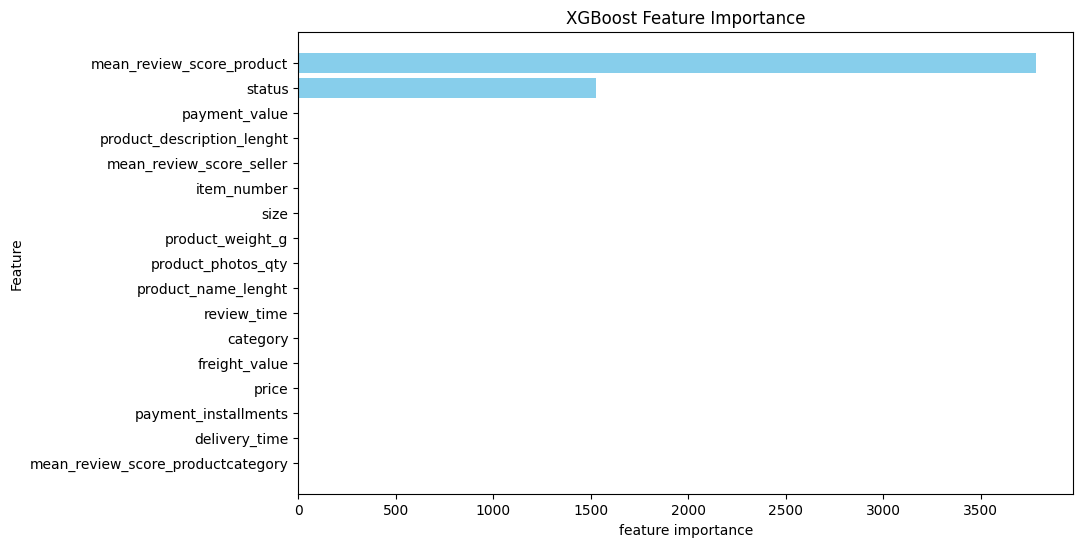

In [ ]:
#feature importance of XGB
xgb_importance = XGB_model.get_booster().get_score(importance_type='gain')
importance_dict = {feature: xgb_importance.get(feature, 0) for feature in features}

# Convert to DataFrame
importance_df_xgb = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by='Gain', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Gain'], color='skyblue')
plt.xlabel('feature importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()



---


* Both models rely heavily on the average product review score for predictions,
with XGB even using only two features.
* This might result in the model being overly simplistic and unable to handle future data effectively.
* To reconfirm the important features, the variables that might lead to data leaking are removed and the model is retrained.


---



# 2. Model without average columns--just to check the feature importance

In [ ]:
# Remove columns that might cause data leakage like 'mean_review_score_product','mean_review_score_seller','mean_review_score_productcategory'
columns_to_keep_new = ['review_score','payment_value', 'review_time',
               'status', 'delivery_time', 'payment_installments',
               'price', 'freight_value','category','product_name_lenght',
               'product_description_lenght','product_photos_qty',
               'product_weight_g','size','item_number']

df = df[columns_to_keep_new]  # Keep only the specified columns

In [ ]:
# Separate the target variable and features
y_value = df['review_score'] # set the y
y_values = np.ravel(y_value) # Flatten to 1D array
x_values = df.drop('review_score', axis=1)

# Split into training and test sets (80/20 split with stratification)
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# Print dataset shapes and feature metadata
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_test.columns)
print(X_test.dtypes)

(72277, 14)
(18070, 14)
(72277,)
(18070,)
Index(['payment_value', 'review_time', 'status', 'delivery_time',
       'payment_installments', 'price', 'freight_value', 'category',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'size', 'item_number'],
      dtype='object')
payment_value                 float64
review_time                     int64
status                          int64
delivery_time                   int64
payment_installments          float64
price                         float64
freight_value                 float64
category                         int8
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
size                          float64
item_number                     int64
dtype: object


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support

# Train baseline GBDT model
GBDT_algo = GBDT()
GBDT_model = GBDT_algo.fit(X_train, Y_train)

# Train baseline XGBoost model
XGB_algo = XGB()
XGB_model = XGB_algo.fit(X_train, Y_train)


models = [ GBDT_model, XGB_model]
names = [  'GBDT', 'XGBDT']

train score

In [ ]:
# Evaluate Training Set Performance
for i in range(2):
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_train)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')


  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: GBDT
Macro Precision: 0.7968389594739094
Macro Recall: 0.6255763498387759
Macro F1-score: 0.6474944424326832


Model: XGBDT
Macro Precision: 0.8503515708639369
Macro Recall: 0.6804608101162466
Macro F1-score: 0.7156402646709542




test score

In [ ]:
# Evaluate Test Set Performance
for i in range(2):
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_test)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: GBDT
Macro Precision: 0.7903524474018481
Macro Recall: 0.6250778397713718
Macro F1-score: 0.646661629169063


Model: XGBDT
Macro Precision: 0.7759176940530184
Macro Recall: 0.638822571433341
Macro F1-score: 0.6627561324071978




### Accuracy and Classification Reports

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Evaluate GBDT
y_pred_prob = GBDT_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)      # Threshold predictions

print("GBDT Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

# Evaluate XGBoost
y_pred_prob = XGB_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("XGB Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

GBDT Accuracy: 0.8110680686220254

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.28      0.41      4222
         1.0       0.82      0.97      0.89     13848

    accuracy                           0.81     18070
   macro avg       0.79      0.63      0.65     18070
weighted avg       0.80      0.81      0.78     18070

XGB Accuracy: 0.8124515771997787

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.31      0.44      4222
         1.0       0.82      0.96      0.89     13848

    accuracy                           0.81     18070
   macro avg       0.78      0.64      0.66     18070
weighted avg       0.80      0.81      0.78     18070



The XGB model has a slight overfitting, so using hyperparameters

**XGB-using hyperparameters**

In [ ]:
# Use randomized search with cross-validation to tune hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# we get a load of warnings running the code so will supress them
import warnings
warnings.filterwarnings("ignore")

# Define random search function for reuse
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=2015,
                          scoring='precision_macro', n_iter=20, refit=True)
  clf.fit(X_train, Y_train)
  return clf.best_params_

In [ ]:
# Define hyperparameter space
XGB_tuned_parameters = {
    'n_estimators': randint(25, 250), # number of trees
    'eta': uniform(loc=0.01, scale=4.99),  # learning rate
    'objective': ['binary:logistic', 'binary:hinge'],  # objective is the same as criterion
    'max_depth': randint(2, 7)  # Tree depth
}

# Find best hyperparameters
XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, X_train, Y_train)

In [ ]:
# Train XGBoost with best parameters
XGB_algo = XGB(**XGB_best_params)
XGB_model = XGB_algo.fit(X_train, Y_train)

# score the models
models = [XGB_model]
names = ['XGBDT']

# Evaluate tuned XGB on train
for i in range(1):
  print(f"train score")
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_train)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


# Evaluate tuned XGB on test
for i in range(1):
  print(f"test score")
  print(f"Model: {names[i]}")
  predict = models[i].predict(X_test)
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

train score
Model: XGBDT
Macro Precision: 0.7881546644228361
Macro Recall: 0.6166165508699126
Macro F1-score: 0.6356850785634697


test score
Model: XGBDT
Macro Precision: 0.7914735334402352
Macro Recall: 0.6193846754955542
Macro F1-score: 0.6393674144142375




In [ ]:
# Final accuracy and classification report

y_pred_prob = XGB_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print("XGB Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

XGB Accuracy: 0.8094078583287216

Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.26      0.39      4222
         1.0       0.81      0.98      0.89     13848

    accuracy                           0.81     18070
   macro avg       0.79      0.62      0.64     18070
weighted avg       0.80      0.81      0.77     18070



### Confusion Matrix

GBDT Confusion Matrix
XGB Confusion Matrix


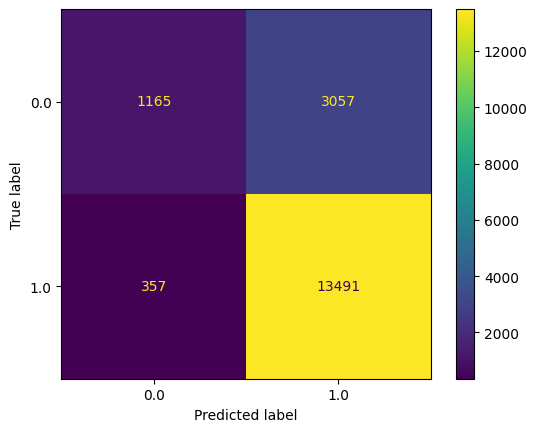

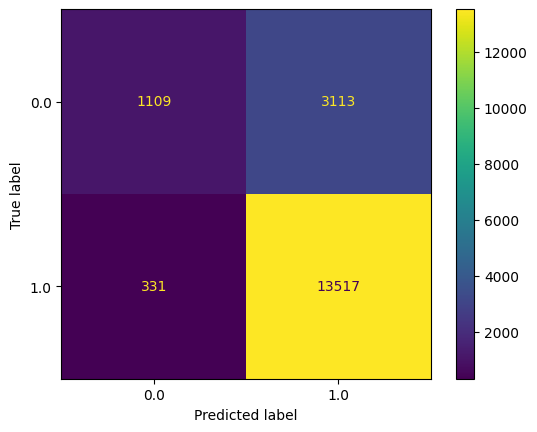

In [ ]:
#draw confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay as CM

# GBDT
print("GBDT Confusion Matrix")
predict = GBDT_model.predict(X_test)
print(CM.from_predictions(Y_test, predict))

# XGB
print("XGB Confusion Matrix")
predict = XGB_model.predict(X_test)
CM.from_predictions(Y_test, predict)

The `GBDT model` is good at correctly predicting “Yes”, but it often makes mistakes when the true answer is “No” — it calls some of those “Yes” by mistake.


The `XGB model` makes fewer mistakes than GBDT, especially when the true answer is “No.” It does a slightly better job overall at telling “Yes” from “No.”

# feature importance

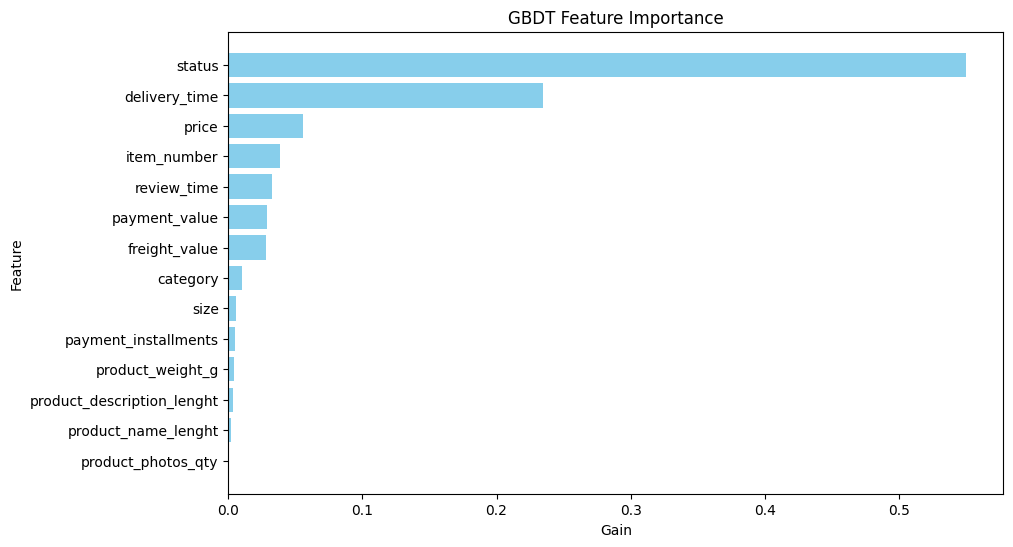

In [ ]:
#feature importance of GBDT
import matplotlib.pyplot as plt
importances = GBDT_model.feature_importances_

X_train.columns=['payment_value', 'review_time',
               'status', 'delivery_time', 'payment_installments',
               'price', 'freight_value','category','product_name_lenght',
               'product_description_lenght','product_photos_qty',
               'product_weight_g','size','item_number']
features = X_train.columns

# Get feature importances from trained GBDT model
gbdt_importance = GBDT_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': gbdt_importance
}).sort_values(by='Importance', ascending=False)

# Plot GBDT Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('GBDT Feature Importance')
plt.gca().invert_yaxis()         # Most important feature at top
plt.show()

The model relies heavily on `status` and `delivery_time` when predicting review scores

### XGB Feature Importance

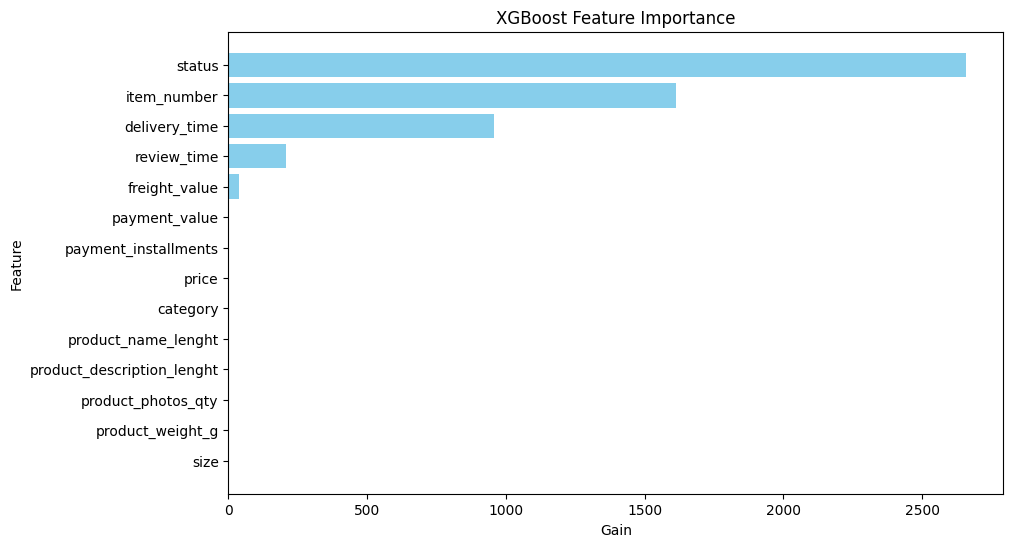

In [ ]:
# Get feature importances from trained XGB model, using 'gain' as the metric
xgb_importance = XGB_model.get_booster().get_score(importance_type='gain')

# Ensure all features are accounted for in the importance dict
importance_dict = {feature: xgb_importance.get(feature, 0) for feature in features}

# Create DataFrame and sort
importance_df_xgb = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
}).sort_values(by='Gain', ascending=False)

# Plot XGBoost Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df_xgb['Feature'], importance_df_xgb['Gain'], color='skyblue')
plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()   # Most important feature at top
plt.show()

XGB also identifies `status` and `delivery_time` as key predictors but distributes importance more smoothly among other features as well.